In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Paths to data and labels
TRAIN_DATA_PATH = r'D:\UniGe\2\CV\Babel Project\Normalized Data\train_ntu_sk_60_pre.npy'
VAL_DATA_PATH   = r'D:\UniGe\2\CV\Babel Project\Normalized Data\val_ntu_sk_60_pre.npy'
TRAIN_LABEL_PATH = r'D:\UniGe\2\CV\Babel Project\BABEL\action_recognition\data\release\train_label_60.pkl'
VAL_LABEL_PATH   = r'D:\UniGe\2\CV\Babel Project\BABEL\action_recognition\data\release\val_label_60.pkl'

In [13]:
# Hyperparameters
BATCH_SIZE     = 64
LR             = 3e-4       # reduced learning rate
WEIGHT_DECAY   = 1e-4
EPOCHS         = 50
EARLY_STOP     = 20
WARMUP_EPOCHS  = 5          # epochs to train with shuffle before sampler
DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Dataset class
class PoseDataset(Dataset):
    def __init__(self, data_path, label_path):
        self.data = np.load(data_path)
        with open(label_path, 'rb') as f:
            labels = pickle.load(f)[1][0]
        self.labels = np.array(labels, dtype=int)
        assert len(self.data) == len(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = np.squeeze(self.data[idx], axis=-1)  # (3, T, 25)
        y = self.labels[idx]
        return torch.from_numpy(x).float(), y

# TCN components with BatchNorm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(n_inputs, n_outputs, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(n_outputs, n_outputs, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.bn1, self.relu1, self.dropout1,
            self.conv2, self.chomp2, self.bn2, self.relu2, self.dropout2
        )
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i-1]
            padding = (kernel_size - 1) * dilation
            layers.append(
                TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                              dilation=dilation, padding=padding,
                              dropout=dropout)
            )
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class PoseTCN(nn.Module):
    def __init__(self, in_dim=75, num_classes=60,
                 num_channels=[64, 64, 64], kernel_size=3, dropout=0.2):
        super().__init__()
        self.tcn = TemporalConvNet(in_dim, num_channels,
                                   kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        N, C, T, V = x.size()
        x = x.permute(0, 2, 3, 1).contiguous().view(N, T, C * V).transpose(1, 2)
        y = self.tcn(x)
        out = y[:, :, -1]
        out = self.dropout(out)
        return self.fc(out)

In [10]:
# Load datasets
train_ds = PoseDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH)
val_ds   = PoseDataset(VAL_DATA_PATH,   VAL_LABEL_PATH)

# Sampler for class balance\class_counts = np.bincount(train_ds.labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_ds.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
# shuffle loader for warmup, sampler loader thereafter
dl_train_shuffle = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dl_train_sampler = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
dl_val   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Model, loss, optimizer, scheduler
model = PoseTCN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Training loop with early stopping
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
best_val_loss = float('inf')
patience_counter = 0
os.makedirs('checkpoints', exist_ok=True)

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\utils\weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [11]:
for epoch in range(1, EPOCHS+1):
    # choose loader
    loader = dl_train_shuffle if epoch <= WARMUP_EPOCHS else dl_train_sampler

    # Training\    model.train()
    tloss, tacc, tsamples = 0, 0, 0
    for x, y in tqdm(loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE).long()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        preds = out.argmax(dim=1)
        tloss += loss.item() * x.size(0)
        tacc  += (preds==y).sum().item()
        tsamples += x.size(0)
    train_loss = tloss/tsamples
    train_acc  = tacc/tsamples

    # Validation
    model.eval()
    vloss, vacc, vsamples = 0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(dl_val, desc=f"Epoch {epoch}/{EPOCHS} [Val]"):
            x, y = x.to(DEVICE), y.to(DEVICE).long()
            out = model(x)
            loss = criterion(out, y)
            preds = out.argmax(dim=1)
            vloss += loss.item() * x.size(0)
            vacc  += (preds==y).sum().item()
            vsamples += x.size(0)
    val_loss = vloss/vsamples
    val_acc  = vacc/vsamples

    # Scheduler, early stopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'checkpoints/best_pose_tcn.pth')
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP:
            print(f"Early stopping at epoch {epoch}")
            break

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: train loss {train_loss:.4f}, acc {train_acc:.4f} | val loss {val_loss:.4f}, acc {val_acc:.4f}")

Epoch 1/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 240.90it/s]


Epoch 1: train loss 3.2067, acc 0.2633 | val loss 2.7929, acc 0.3136


Epoch 2/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 277.34it/s]


Epoch 2: train loss 2.6927, acc 0.3336 | val loss 2.6644, acc 0.3351


Epoch 3/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 275.53it/s]


Epoch 3: train loss 2.5934, acc 0.3478 | val loss 2.6259, acc 0.3395


Epoch 4/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 279.87it/s]


Epoch 4: train loss 2.5341, acc 0.3573 | val loss 2.6144, acc 0.3408


Epoch 5/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 284.06it/s]


Epoch 5: train loss 2.4771, acc 0.3657 | val loss 2.5763, acc 0.3458


Epoch 6/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 278.90it/s]


Epoch 6: train loss 2.8640, acc 0.2558 | val loss 2.9834, acc 0.2822


Epoch 7/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 277.95it/s]


Epoch 7: train loss 2.7213, acc 0.2843 | val loss 3.0027, acc 0.2744


Epoch 8/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 285.77it/s]


Epoch 8: train loss 2.6422, acc 0.3011 | val loss 2.9604, acc 0.2743


Epoch 9/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 264.80it/s]


Epoch 9: train loss 2.5625, acc 0.3139 | val loss 3.0296, acc 0.2650


Epoch 10/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 278.22it/s]


Epoch 10: train loss 2.4736, acc 0.3314 | val loss 2.9778, acc 0.2873


Epoch 11/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 281.77it/s]


Epoch 11: train loss 2.4192, acc 0.3458 | val loss 3.0345, acc 0.2701


Epoch 12/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 276.98it/s]


Epoch 12: train loss 2.2897, acc 0.3732 | val loss 2.9693, acc 0.2781


Epoch 13/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 262.76it/s]


Epoch 13: train loss 2.2501, acc 0.3828 | val loss 2.9625, acc 0.2761


Epoch 14/50 [Val]: 100%|██████████| 267/267 [00:00<00:00, 270.28it/s]


Epoch 14: train loss 2.2182, acc 0.3891 | val loss 3.1119, acc 0.2441


Epoch 15/50 [Val]: 100%|██████████| 267/267 [00:01<00:00, 266.73it/s]

Early stopping at epoch 15


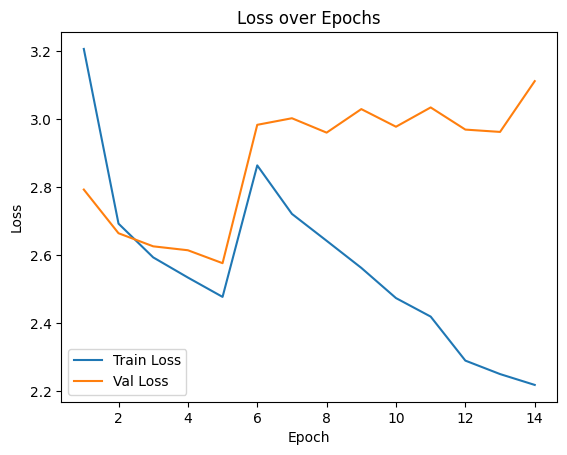

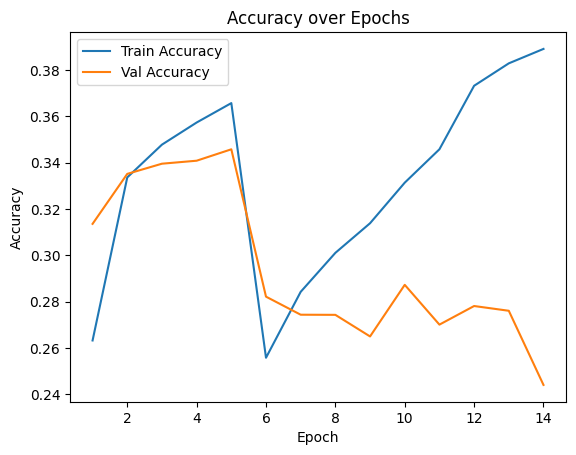

In [12]:
# Plot training history
epochs = range(1, len(history['train_loss'])+1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over Epochs'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'],   label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over Epochs'); plt.legend(); plt.show()


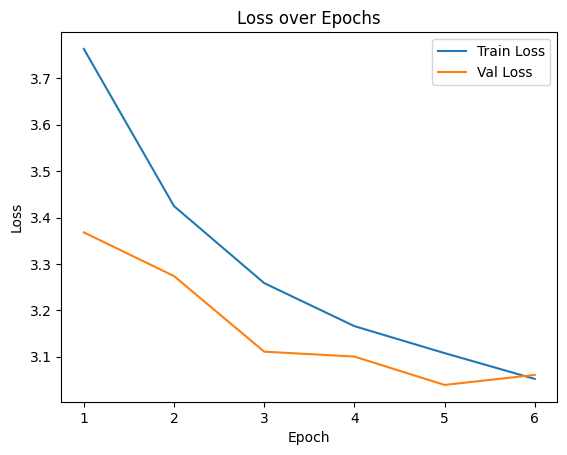

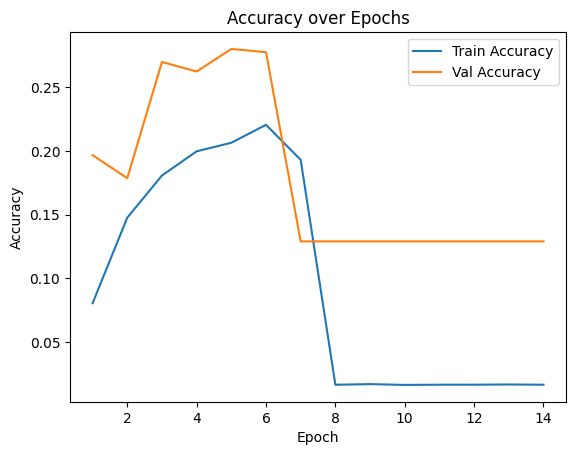

In [7]:
# Plot training history
epochs = range(1, len(history['train_loss'])+1)
plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over Epochs'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, history['train_acc'], label='Train Accuracy')
plt.plot(epochs, history['val_acc'],   label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over Epochs'); plt.legend(); plt.show()
